In [16]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib notebook

%load_ext autoreload
%autoreload 2

from utils.DataPrepUtils import xy_backtest
from ModelTesters.ModelTester import ModelTester
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
data = pd.read_csv('data/filter_data.csv')
hurst_estimates = pd.read_csv('data/hurst_estimates.csv')
hurst_estimates.set_index('Unnamed: 0', inplace=True)

In [6]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri, numpy2ri
from rpy2.robjects.vectors import FloatVector

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Setup to parse to R
pandas2ri.activate()
ts = ro.r('ts')
forecast = importr('forecast')

## Auto Arima model from R

In [9]:
class AutoArima():
    
    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.arima_models = []
    
    
    def fit(self, data, labels):
        self.data = data
    
    def predict(self, data, bar=None, use_every=1):
        all_data = np.hstack([self.data, data])
        results = np.zeros((len(data), self.horizon))
        
        for i in range(0, len(data), use_every):
            arima_model = forecast.auto_arima(all_data[len(self.data) + i - self.back_horizon: len(self.data) + i])
            arima_forecast = forecast.forecast(arima_model, h=self.horizon)
            arima_output = dict(zip(arima_forecast.names, map(list,list(arima_forecast))))
            self.arima_models.append(dict(zip(arima_forecast.names, map(list,list(arima_forecast)))))
            
            results[i] = np.array(arima_output['mean'])
            
            if bar is not None:
                bar.progress()

        return results

In [10]:
from utils.ErrorMetrics import calculate_all_errors
import datetime as dt

def speed_up_calc(tester, data, horizon, use_every=1):
    # Loading bar
    split = int(0.20 * len(data))
    tester.progressBar.set_length(len(data.columns) * (len(data) - split) // use_every)
    start = dt.datetime.now()
    
    # walk speed up
    for i, column in enumerate(data.keys()):

        # Split into train and test data
        train, test = data[column][:split].values, data[column][split:].values
        
        # Round to be a multiple of the horizon
        test = test[:len(test) - len(test) % horizon]

        # Fit and make predictions
        tester.model.fit(train, train)
        pred = tester.model.predict(test, bar=tester.progressBar, use_every=use_every)
        tester.predictions[column] = pred

        # calculate and save errors
        errors = {}
        for key, value in calculate_all_errors(train, test, pred, horizon).items():
            errors[key] = [value]

        t = pd.DataFrame.from_dict(errors)
        t.set_index(keys=[[column]], inplace=True)
        tester.errors = tester.errors.append(t)
        
        # calculate timing
        end = dt.datetime.now()
        print("Iteration in:", (dt.datetime.now() - start).microseconds / 10**6, "s")

In [55]:
def lower_horizon(trained_tester, new_tester, data, horizon, use_every=1):
    split = int(0.20 * len(data) * 1)
    new_tester.predictions = {}
    new_tester.progressBar.set_length(len(trained_tester.predictions))
    
    for key, col in trained_tester.predictions.items():
        # Create train test split
        pred = col[:, :horizon]
        train, test = data[key][:split], data[key][split:]

        # Format data into previous data and values to predict
        indexer = np.arange(horizon)[None, :] + use_every * np.arange((len(test)) // (horizon + use_every))[:, None]
        test = test.values[indexer]

        indexer = np.arange(horizon)[None, :] + use_every * np.arange((len(train)) // (horizon + use_every))[:, None]
        train = train.values[indexer]

        pred, test = pred[:min(len(pred), len(test))], test[:min(len(pred), len(test))]
        new_tester.predictions[key] = pred

        # Round to be a multiple of the horizon
        test = test[:len(test) - len(test) % horizon]
        pred, test = pred[:min(len(pred), len(test))], test[:min(len(pred), len(test))]

        # Compute errors
        errors = {}
        for err, value in calculate_all_errors(train, test.flatten(), pred, horizon, expand_actual=False).items():
            errors[err] = [value]

        t = pd.DataFrame.from_dict(errors)
        t.set_index(keys=[[key]], inplace=True)
        new_tester.errors = new_tester.errors.append(t)
        
        new_tester.progressBar.progress()

## Forecasts

In [11]:
# Note: horizon doesnt impact prediction, so can just do 60 minutes and take the first 1 or 5 samples

In [12]:
horizon = 60
arima = AutoArima(horizon, 120)
tester = ModelTester(data, arima, horizon, 0.2)

In [19]:
load_predictions = True

if not load_predictions:
    # Calculate predictions
    speed_up_calc(tester, data, horizon, use_every=60)
else:
    # load predictions
    tester.predictions = pickle.load(open('results/arima_preds.pck', 'rb'))
    
    # remove unused predictions
    for key in tester.predictions.keys():
        tester.predictions[key] = tester.predictions[key][np.where(tester.predictions[key].any(axis=1))[0]]

In [36]:
# Save predictions
# pickle.dump(tester.predictions, open('results/arima_preds.pck', 'wb+'))

## 1 minute horizon

In [25]:
horizon = 1

one_min_tester = ModelTester(data, arima, horizon, 0.2)

In [35]:
lower_horizon(tester, one_min_tester, data, horizon, use_every=60)

Progress: [####################] 100.0%


In [27]:
one_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE2,MASE3,MEAN_ASE
window_1_0,25.045907,87.053761,20.475501,9.892797,0.108425,0.122395,0.122395,0.082409
window_1_1,26.734307,109.189741,13.855417,7.805132,0.139777,0.145432,0.145432,0.089319
window_1_2,37.463845,113.893880,24.799408,13.435911,0.119967,0.158550,0.158550,0.116291
window_1_3,43.086570,126.822227,16.685415,12.884629,0.111319,0.159809,0.159809,0.108882
window_1_4,44.156384,118.823947,35.892003,15.788552,0.154798,0.175734,0.175734,0.156617


<IPython.core.display.Javascript object>


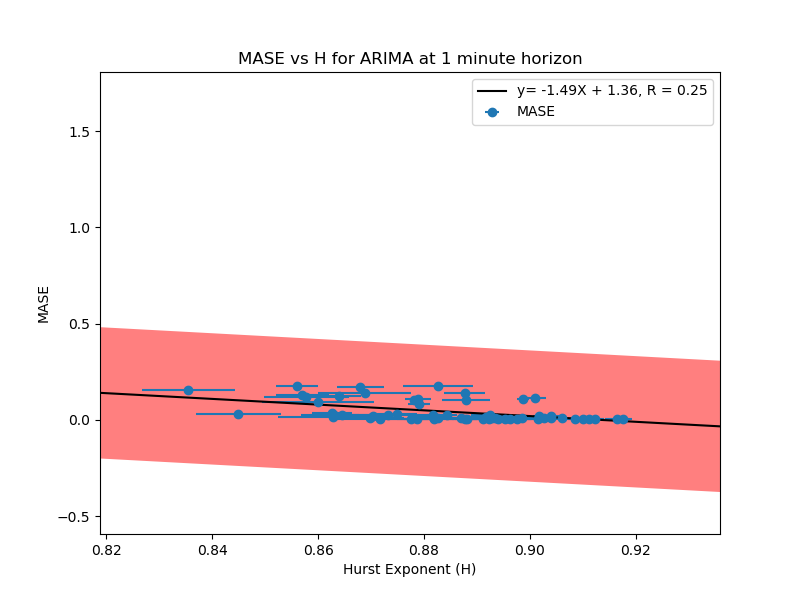

Text(0.5,1,'MASE vs H for ARIMA at 1 minute horizon')

In [29]:
one_min_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for ARIMA at 1 minute horizon')
# plt.ylim([-300, 500])

## 5 minute horizon

In [42]:
horizon = 5

five_min_tester = ModelTester(data, arima, horizon, 0.2)

In [43]:
lower_horizon(tester, five_min_tester, data, horizon=5, use_every=60)

Progress: [####################] 100.0%


In [37]:
five_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE2,MASE3,MEAN_ASE
window_1_0,50.232523,162.423256,43.667907,16.317440,0.229189,0.774869,0.774869,0.163215
window_1_1,56.951788,221.774024,25.222718,14.099685,0.296372,0.955931,0.955931,0.188905
window_1_2,78.533401,223.797482,514.367312,23.593816,0.257212,1.017066,1.017066,0.247513
window_1_3,87.249273,229.302630,60.680844,23.781893,0.224237,0.979222,0.979222,0.225422
window_1_4,97.780101,244.037454,120.552581,28.067438,0.326089,1.103717,1.103717,0.340960


<IPython.core.display.Javascript object>


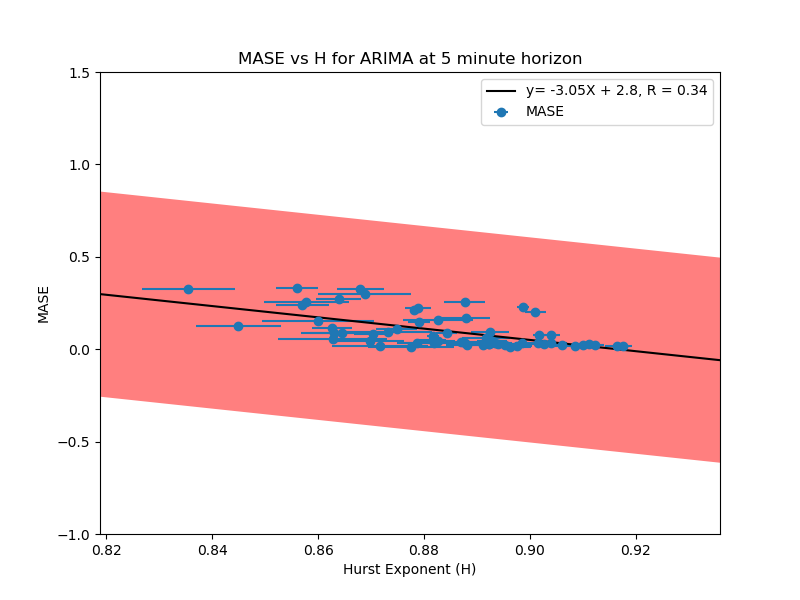

(-1, 1.5)

In [47]:
five_min_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for ARIMA at 5 minute horizon')
plt.ylim([-1, 1.5])

## 60 minute horizon

In [48]:
horizon = 60

sixty_min_tester = ModelTester(data, arima, horizon, 0.2)

In [49]:
lower_horizon(tester, sixty_min_tester, data, horizon=60, use_every=60)

Progress: [####################] 100.0%


In [50]:
sixty_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE2,MASE3,MEAN_ASE
window_1_0,129.918294,304.513831,188.296673,41.102029,0.746181,4.919198,4.919198,0.421587
window_1_1,176.537725,1262.907083,126.179493,35.644177,0.942981,6.967888,6.967888,0.597941
window_1_2,170.738543,356.082176,220.592354,48.995822,0.567437,4.639761,4.639761,0.555847
window_1_3,220.868597,448.570096,156.900789,50.146145,0.561815,4.708478,4.708478,0.559801
window_1_4,243.485227,478.197414,333.422804,64.285452,0.799616,4.035220,4.035220,0.835493


<IPython.core.display.Javascript object>


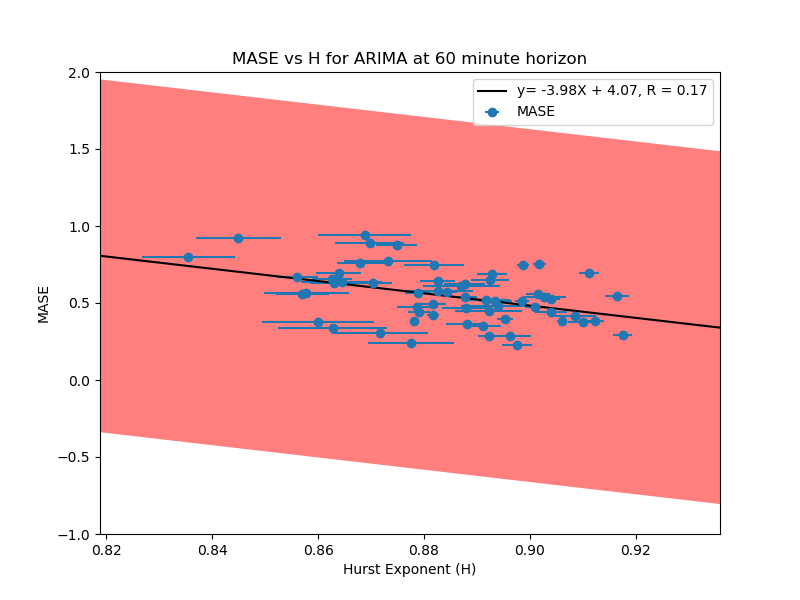

(-1, 2)

In [54]:
sixty_min_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for ARIMA at 60 minute horizon')
plt.ylim([-1, 2])